<a href="https://colab.research.google.com/github/yoheikikuta/DeepGamblers-tensorflow/blob/master/colab/Deepgamblers_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Gamblers

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.0.0'

In [0]:
from tensorflow.keras import layers
import numpy as np

## MNIST data

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
tf.one_hot(train_labels, depth=10)[0:3]

<tf.Tensor: id=8, shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [0]:
train_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(train_labels, depth=10))
))

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(test_labels, depth=10))
))

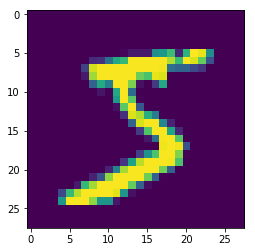

In [10]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0].reshape((28, 28)))

In [0]:
it = iter(train_dataset)

In [0]:
img, label = next(it)

In [13]:
label

<tf.Tensor: id=34, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

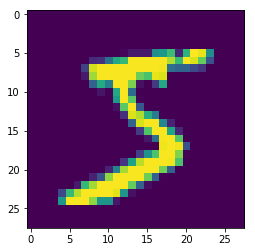

In [14]:
plt.imshow(img.numpy().reshape((28, 28)))

## Model

In [0]:
class fourLayerCNN(tf.keras.Model):
    """Simple 4-layer CNN"""

    def __init__(self, o=4.4, output_dim=11, name='cnn', **kwargs) -> None:
        super(fourLayerCNN, self).__init__(name=name, **kwargs)
        self.o = o
        self.output_dim = output_dim
        self.input_layer = layers.InputLayer(input_shape=(28, 28, 1))
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_2 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_3 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_4 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(self.output_dim)
        self.prob = layers.Softmax()

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x = self.conv2d_4(x)
        x = self.flatten(x)
        x = self.dense(x)
        prob = self.prob(x)
        return prob
    
    def weighted_prob(self, inputs):
        prob = self.call(inputs)
        class_pred, abstention = tf.split(prob, [self.output_dim - 1, 1], 1)
        abstention /= self.o
        return tf.concat([class_pred, abstention], 1)

In [0]:
def compute_loss(model, x, y):
    weighted_prob = model.weighted_prob(x)
    label_shape = y.shape
    extended_label = tf.concat([y, tf.constant(1.0, shape=[label_shape[0], 1])], 1)
    log_arg = tf.reduce_sum(extended_label * weighted_prob, 1)
    cross_ent = -tf.reduce_sum(tf.math.log(log_arg))
    return cross_ent

In [0]:
def train(model, optimizer, test_loss, train_dataset, test_dataset):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x_batch_train, y_batch_train)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    for (x_batch_test, y_batch_test) in test_dataset:
        test_loss(compute_loss(model, x_batch_test, y_batch_test))

## Training

In [0]:
import time

In [0]:
train_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(train_labels, depth=10))
)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(test_labels, depth=10))
)).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [159]:
start = time.time()
cnn = fourLayerCNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(2):
    print(f"Start of epoch {epoch + 1}")
    test_loss = tf.keras.metrics.Mean()
    train(cnn, optimizer, test_loss, train_dataset, test_dataset)
    print(f"  test loss: {test_loss.result()}")

end = time.time()
print(f"TRAINING TIME: {end - start} [sec]")

Start of epoch 1
  test loss: 120.27222442626953
Start of epoch 2
  test loss: 119.43754577636719
TRAINING TIME: 536.2885119915009 [sec]


In [0]:
it = iter(test_dataset)
img, label = next(it)

In [161]:
img.shape

TensorShape([100, 28, 28, 1])

In [164]:
cnn(img)[:3]

<tf.Tensor: id=1096619, shape=(3, 11), dtype=float32, numpy=
array([[2.1381481e-17, 3.0288554e-15, 1.4453471e-18, 3.9382879e-16,
        7.8786298e-18, 7.9571347e-17, 2.2277005e-19, 1.5161339e-09,
        5.8637267e-19, 1.5712204e-19, 1.0000000e+00],
       [8.2323093e-10, 9.9889177e-01, 1.1404386e-09, 2.8735774e-09,
        1.0531793e-09, 2.2582645e-09, 4.7212203e-09, 6.8174251e-07,
        8.4361523e-10, 2.5971305e-09, 1.1075439e-03],
       [1.1290270e-12, 3.3538842e-07, 2.9756042e-13, 2.3691763e-12,
        4.7357544e-15, 4.3287354e-13, 3.5894486e-13, 2.5838958e-08,
        5.8932500e-14, 9.0021126e-16, 9.9999964e-01]], dtype=float32)>

In [165]:
label[:3]

<tf.Tensor: id=1096623, shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
pred = []
ans = []
for p, l in zip(np.array(cnn(img)), np.array(label)):
    pred.append(np.argmax(p))
    ans.append(np.argmax(l))

In [182]:
pred[:10]

[10, 1, 10, 10, 10, 10, 10, 10, 1, 10]

In [183]:
ans[:10]

[3, 1, 3, 6, 0, 9, 5, 5, 1, 9]

## Trial and Errors

In [0]:
a = [1, 2, 3, 4, 5]

In [22]:
a[:-1]

[1, 2, 3, 4]

In [23]:
a[-1]

5

In [0]:
test_model = fourLayerCNN(1.2)

In [0]:
check_data = tf.constant(train_images[0])

In [160]:
check_data.shape

TensorShape([28, 28, 1])

In [161]:
tf.shape(tf.expand_dims(check_data, 0))  # Add batch dim.

<tf.Tensor: id=1601, shape=(4,), dtype=int32, numpy=array([ 1, 28, 28,  1], dtype=int32)>

In [0]:
prob = test_model(tf.expand_dims(check_data, 0))

In [163]:
prob.shape

TensorShape([1, 11])

In [116]:
abstention = test_model.weighted_prob(tf.expand_dims(check_data, 0))

InvalidArgumentError: ignored

In [0]:
a = tf.constant([[0,1,2,3,4,5,6,7,8,9,10]], dtype=tf.float32)

In [129]:
a.shape

TensorShape([1, 11])

In [130]:
tf.slice(a, [:, 0], [:, 3])

SyntaxError: ignored

In [0]:
b, c = tf.split(a, [10, 1], 1)

In [132]:
b, c

(<tf.Tensor: id=1264, shape=(1, 10), dtype=float32, numpy=array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], dtype=float32)>,
 <tf.Tensor: id=1265, shape=(1, 1), dtype=float32, numpy=array([[10.]], dtype=float32)>)

In [133]:
c / 2.0

<tf.Tensor: id=1267, shape=(1, 1), dtype=float32, numpy=array([[5.]], dtype=float32)>

In [138]:
tf.concat([b, c], 1)

<tf.Tensor: id=1270, shape=(1, 11), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]],
      dtype=float32)>

In [164]:
test_model.weighted_prob(tf.expand_dims(check_data, 0))

<tf.Tensor: id=1781, shape=(1, 11), dtype=float32, numpy=
array([[ 0.       ,  0.8333333,  1.6666666,  2.5      ,  3.3333333,
         4.1666665,  5.       ,  5.833333 ,  6.6666665,  7.4999995,
        10.       ]], dtype=float32)>

In [175]:
tf.one_hot(train_labels, depth=10)[0:3]

<tf.Tensor: id=1813, shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [184]:
tf.data.Dataset.from_tensors(tf.one_hot(train_labels, depth=10))

<TensorDataset shapes: (60000, 10), types: tf.float32>

In [189]:
train_dataset

<ZipDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>

In [0]:
shape = label.shape

In [81]:
shape[0]

NameError: ignored

In [0]:
class fourLayerCNN(tf.keras.Model):
    """Simple 4-layer CNN"""

    def __init__(self, o=4.4, output_dim=11, name='cnn', **kwargs) -> None:
        super(fourLayerCNN, self).__init__(name=name, **kwargs)
        self.o = o
        self.output_dim = output_dim
        self.input_layer = layers.InputLayer(input_shape=(28, 28, 1))
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_2 = layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu')
        self.dropout = layers.Dropout(rate=0.2)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(self.output_dim)
        self.prob = layers.Softmax()

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x = self.conv2d_4(x)
        x = self.flatten(x)
        x = self.dense(x)
        prob = self.prob(x)
        return prob

In [0]:
def compute_loss(model, x, y):
    weighted_prob = model(x)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=weighted_prob, labels=y)
    return cross_ent